# Machine learning for genetic data

## Introduction

The goal of this practical session is to manipulate high-dimensional, low sample-size data that is typical of many genetic applications.

Here we will work with GWAS data from _Arabidopsis thaliana_, which is a plant model organism. The genotypes are hence described by **Single Nucleotide Polymorphisms, or SNPs**. Our goal will be to use this data to identify regions of the genome that can be linked with various growth and flowering traits (**phenotypes**).

## Data description

* `data/athaliana_small.X.txt` is the design matrix. As many rows as samples, as many columns as SNPs
* the SNPs are given (in order) in `data/athaliana_small.snps.txt`. 
* the samples are given (in order) in `data/athaliana.samples.txt`.

* the phenotypes are given in `data/phenotypes.pheno`. The first two columns give the sample's ID, and all following columns give a phenotype. The header gives the list of all phenotypes. In this session we will use "2W" and "4W", which give the number of days by which the plant grows to be 5 centimeters tall, after either two weeks ("2W") or four weeks ("4W") of vernalization (i.e. the seeds are kept at cold temperatures, similar to winter). Not all phenotypes are available for all samples.

* `data/athaliana.snps_by_gene.txt` contains, for each _A. thaliana_ SNP, the list of genes it is in or near to. (This can be several genes, as it is customary to use a rather large window to compute this, so as to capture potential cis-regulatory effects.)

* the feature network is in `data/athaliana_small.W.txt`. It has been saved as 3 arrays, corresponding to the row, col, and data attributes of a [scipy.sparse coo_matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.coo_matrix.html).

## Loading the data

In [2]:
%pylab inline
#get_ipython().run_line_magic('pylab', 'inline')

Populating the interactive namespace from numpy and matplotlib


#### Read the list of SNP names

In [3]:
with open('data/athaliana_small.snps.txt') as f:
    snp_names = f.readline().split()
    f.close()
print(len(snp_names), snp_names[:10])

9419 ['Chr1_21043_T', 'Chr1_21128_T', 'Chr1_21829_C', 'Chr1_22522_G', 'Chr1_27265_C', 'Chr1_29291_A', 'Chr1_31515_G', 'Chr1_32807_A', 'Chr1_35856_C', 'Chr1_37072_G']


#### Read the list of sample names

In [4]:
samples = list(np.loadtxt('data/athaliana.samples.txt', # file names
                         dtype=int)) # values are integers
print(len(samples), '\n', samples[:10])

1307 
 [9381, 9380, 9378, 9371, 9367, 9363, 9356, 9355, 9354, 9353]


#### Load the design matrix (n samples x p SNPs)

In [5]:
X = np.loadtxt('data/athaliana_small.X.txt',  # file names
               dtype='int') # values are integers

In [6]:
n, p = X.shape
print(n, p)

1307 9419


#### Load the 2W phenotype data

The first phenotype we will work with is called "2W". It describes the number of days required for the bolt height to reach 5 cm, at a temperature of 23°C under 16 hours of daylight per 24 hours, for seeds that have been vernalized for 2 weeks at 5°C (with 8 hours of daylight per 24 hours).

In [7]:
import pandas as pd

In [8]:
# TODO
# read phenotypes from phenotypes.pheno
# only keep samples that have a 2W phenotype.
phenotypes = pd.read_csv("data/phenotypes.pheno", sep = " ")

In [9]:
phenotypes["2W"]

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
1302   NaN
1303   NaN
1304   NaN
1305   NaN
1306   NaN
Name: 2W, Length: 1307, dtype: float64

In [10]:
y_2W = phenotypes.loc[~np.isnan(phenotypes["2W"]), "2W"]

In [11]:
y_2W

404     55.8
802     21.2
806     28.6
807     25.8
808     23.8
        ... 
1062    19.8
1064    22.0
1065    17.0
1066    24.4
1067    19.4
Name: 2W, Length: 152, dtype: float64

In [12]:
samples_with_phenotype = phenotypes[~np.isnan(phenotypes["2W"])]["FID"]

In [13]:
# Restrict X to the samples with a 2W phenotype, in correct order
# X_2W[i] = X[samples.index(samples_with_phenotype[i])]
X_2W = X[np.array([samples.index(sample_id) for sample_id in samples_with_phenotype]), :]
n, p = X_2W.shape
print(n, p)

152 9419


In [14]:
y_2W

404     55.8
802     21.2
806     28.6
807     25.8
808     23.8
        ... 
1062    19.8
1064    22.0
1065    17.0
1066    24.4
1067    19.4
Name: 2W, Length: 152, dtype: float64

In [15]:
# You can delete X now if you want, to free space
del X

## Split the data in a train and test set

We will set aside a test set, containing 20% of our samples, on which to evaluate the quality of our predictive models.

In [16]:
from sklearn import model_selection

In [17]:
X_2W_tr, X_2W_te, y_2W_tr, y_2W_te = \
    model_selection.train_test_split(X_2W, y_2W, test_size=0.2, 
                                     random_state=17)
print(X_2W_tr.shape, X_2W_te.shape)

(121, 9419) (31, 9419)


## Visualize the phenotype

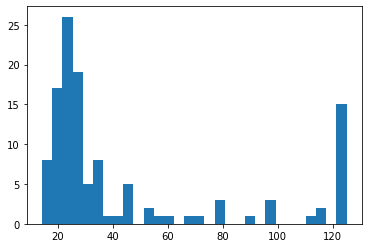

In [18]:
h = plt.hist(y_2W_tr, bins=30)

## T-test

Let us start by running a statistical test for association of each SNP feature with the phenotype.

In [19]:
import statsmodels.api as sm

In [28]:
## This is a duplicate of a previous cell, should be deleted
## p = X_2W_tr.shape[1]

9419

In [20]:
X_snp = sm.add_constant(X_2W[:, 0])
X_snp.shape

(152, 2)

In [21]:
#X_2W_tr[:, 0]
X_snp = sm.add_constant(X_2W_tr[:, 0])
model = sm.regression.linear_model.OLS(y_2W_tr, X_snp)
model.fit().pvalues

const    6.939645e-21
x1       3.237532e-01
dtype: float64

In [29]:
## Test cell
snp_idx = 0
X8snp = X_2W_tr[:, snp_idx]
X_snp = sm.add_constant(X_snp)
est = sm.regression.linear_model.OLS(y_2W_tr, X_snp)
est2 = est.fit()
est2.pvalues[1]

0.32375321392638

In [30]:
pvalues = []
for snp_idx in range(p):
    # only look a the column corresponding to that SNP
    X_snp = X_2W_tr[:, snp_idx]
    # run a linear regression (with bias) between the phenotype and 
    # this SNP
    X_snp = sm.add_constant(X_snp)
    est = sm.regression.linear_model.OLS(y_2W_tr, X_snp)
    est2 = est.fit()
    # get the p-value from the model 
    pvalues.append(est2.pvalues[1])
pvalues = np.array(pvalues)

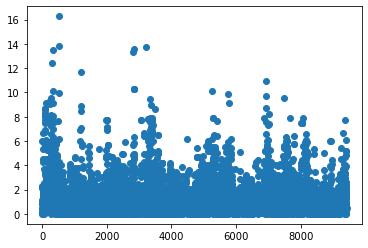

In [31]:
plt.scatter(range(p), -np.log10(pvalues))

(120, 9419) (121, 9419)


array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119])

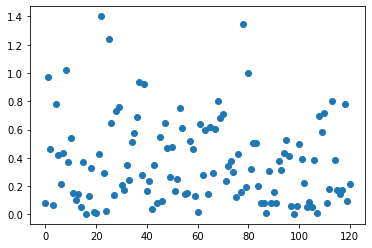

In [33]:
model = sm.regression.linear_model.OLS(y_2W_tr, sm.add_constant(X_2W_tr[:, arange(120)]))
est = model.fit()
pvalues2 = est.pvalues
plt.scatter(range(len(pvalues2)), -log10(pvalues2))


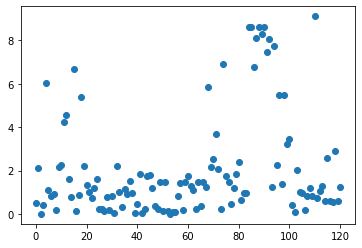

In [48]:
plt.scatter(range(len(pvalues2)), -log10(pvalues[range(len(pvalues2))]))

### Manhattan plot

The common way to visualize such results is by using a Manhattan plot: we will plot all SNPs on the x-axis, and on the y-axis we'll have the opposite of the log base 10 of the p-value. The lower the p-value, the higher the corresponding marker. 

We will also add a horizontal line that corresponds to the _threshold for significance_. Because we are testing multiple hypotheses, we need to lower our threshold accordingly. We will use __Bonferroni correction__ and divide the significance threshold (say, alpha=0.05) by the number of tests, that is, the number of SNPs p.

(0.0, 9419.0)

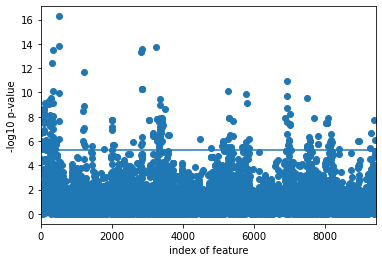

In [49]:
plt.scatter(range(p), # x = SNP position
            -np.log10(pvalues)) # y = -log10 p-value 

# significance threshold according to Bonferroni correction
t = -np.log10(0.05 / p)
plt.plot([0, p], [t, t])

# plot labels
plt.xlabel("index of feature")
plt.ylabel("-log10 p-value")
plt.xlim([0, p])

__What do you observe? Are any SNPs significantly associated with the phenotype? What genes are they in/near?__

## Linear regression 

In [50]:
from sklearn import linear_model

In [51]:
model_lr = linear_model.LinearRegression(fit_intercept=True)
model_lr.fit(X_2W_tr, y_2W_tr)

LinearRegression()

(0.0, 9419.0)

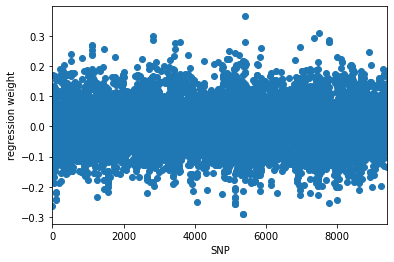

In [52]:
plt.figure(figsize=(6, 4))
plt.scatter(range(p), # x = SNP position
            model_lr.coef_)  # y = regression weights

plt.xlabel("SNP")
plt.ylabel("regression weight")
plt.xlim([0, p])

__What do you observe? How can you interpret these results? Do any of the SNPs strike you as having a strong influence on the phenotype?__

### Model predictive power

In [54]:
from sklearn import metrics

In [55]:
y_2W_lr_pred = model_lr.predict(X_2W_te)

print("Percentage of variance explained (using all SNPs): %.2f" % \
    metrics.explained_variance_score(y_2W_te, y_2W_lr_pred))

Percentage of variance explained (using all SNPs): 0.73


(9.0, 130.0)

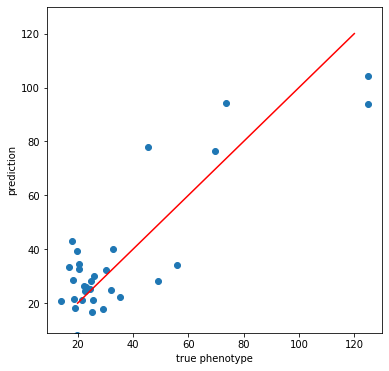

In [72]:
plt.figure(figsize = (6, 6))
plt.scatter(y_2W_te, y_2W_lr_pred)
plt.plot([20, 120], [20, 120], c = "red")
plt.xlabel("true phenotype")
plt.ylabel("prediction")
plt.xlim([np.min(y_2W_te) - 5, np.max(y_2W_te) + 5])
plt.ylim([np.min(y_2W_te) - 5, np.max(y_2W_te) + 5])

## Lasso

In [43]:
alphas = np.logspace(-4., 1., num = 20)

In [44]:
lasso = linear_model.Lasso(fit_intercept = True)
model_l1 = model_selection.GridSearchCV(lasso, 
                                        param_grid = {'alpha': alphas}, 
                                        scoring = 'explained_variance')
model_l1.fit(X_2W_tr, y_2W_tr)

NameError: name 'linear_model' is not defined

(0.0, 9419.0)

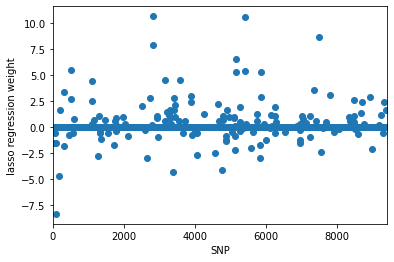

In [77]:
plt.figure(figsize = (6, 4))
plt.scatter(range(p), # x = SNP position
            model_l1.best_estimator_.coef_)  # y = regression weights

plt.xlabel("SNP")
plt.ylabel("lasso regression weight")
plt.xlim([0, p])

__How can you interpret these results? How many SNPs contribute to explaining the phenotype?__

In [83]:
print("%d SNPs selected." % \
    np.nonzero(model_l1.best_estimator_.coef_)[0].shape)

170 SNPs selected.


### Predictive power 

In [84]:
y_2W_l1_pred = model_l1.best_estimator_.predict(X_2W_te)

print("Percentage of variance explained (using %d SNPs): %.2f" % \
     (np.nonzero(model_l1.best_estimator_.coef_)[0].shape[0], 
      metrics.explained_variance_score(y_2W_te, y_2W_l1_pred)))

Percentage of variance explained (using 170 SNPs): 0.60


(13.95, 125.05)

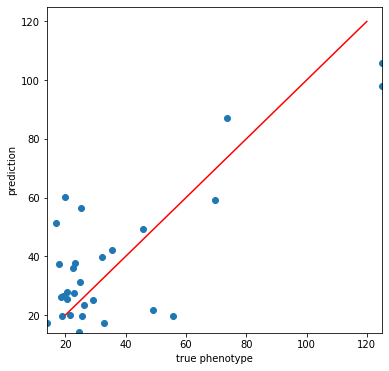

In [88]:
plt.figure(figsize = (6, 6))
plt.scatter(y_2W_te, y_2W_l1_pred)
plt.plot([20, 120], [20, 120], c = "red")
plt.xlabel("true phenotype")
plt.ylabel("prediction")
plt.xlim([np.min(y_2W_te) - 0.05, np.max(y_2W_te) + 0.05])
plt.ylim([np.min(y_2W_te) - 0.05, np.max(y_2W_te) + 0.05])

### Stability

__How stable is the set of selected SNPs, between the different rounds of cross-validation with optimal parameters?__

You can use [sklearn.metrics.jaccard_similarity_score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.jaccard_similarity_score.html), or implement Kuncheva's consistency index.

__Note:__ One could also contemplate using the Jaccard similarity (or another measure of consistency/stability/robustness) as a criterion to select the best hyperparameters. Pay attention, however, to the fact that hyperparameters selecting no features at all or all the features will have very good consistency.

## Elastic net

One solution to make the lasso more stable is to use a combination of the l1 and l2 regularizations.

We are now minimizing the loss + a linear combination of an l1-norm and an l2-norm over the regression weights. This imposes sparsity, but encourages correlated features to be selected together, where the lasso would tend to pick only one (at random) of a group of correlated features.

The elastic net is implemented in scikit-learn's [linear_model.ElasticNet](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html#sklearn.linear_model.ElasticNet).

In [46]:
from sklearn import linear_model

In [47]:
# Parameters grid
alphas = np.logspace(-4., 1., num = 15)
ratios = np.linspace(0.5, 1., num = 3)

In [48]:
enet = linear_model.ElasticNet(fit_intercept=True)
model_l1l2 = model_selection.GridSearchCV(enet, 
                                        param_grid = {'alpha': alphas, 
                                                    'l1_ratio': ratios}, 
                                        scoring = 'explained_variance')
model_l1l2.fit(X_2W_tr, y_2W_tr)

/home/vivien/anaconda3/envs/mlgen/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.644529598306793, tolerance: 12.711796489583337
  model = cd_fast.enet_coordinate_descent(
/home/vivien/anaconda3/envs/mlgen/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.52658179618194, tolerance: 13.814679773195875
  model = cd_fast.enet_coordinate_descent(
/home/vivien/anaconda3/envs/mlgen/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.227865444944483, tolerance: 11.77034608247423
  model = cd_fast.enet_coordinate_descent(
/home/vivien/anaconda3/envs/mlgen/lib/python3.8/

/home/vivien/anaconda3/envs/mlgen/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22.737893736547424, tolerance: 12.768815958762888
  model = cd_fast.enet_coordinate_descent(
/home/vivien/anaconda3/envs/mlgen/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36.704738799828576, tolerance: 12.711796489583337
  model = cd_fast.enet_coordinate_descent(
/home/vivien/anaconda3/envs/mlgen/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39.41717108631791, tolerance: 13.814679773195875
  model = cd_fast.enet_coordinate_descent(
/home/vivien/anaconda3/envs/mlgen/lib/python3.8

/home/vivien/anaconda3/envs/mlgen/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44.308812911879926, tolerance: 12.711796489583337
  model = cd_fast.enet_coordinate_descent(
/home/vivien/anaconda3/envs/mlgen/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 45.50877678608171, tolerance: 13.814679773195875
  model = cd_fast.enet_coordinate_descent(
/home/vivien/anaconda3/envs/mlgen/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 43.12280376011209, tolerance: 11.77034608247423
  model = cd_fast.enet_coordinate_descent(
/home/vivien/anaconda3/envs/mlgen/lib/python3.8/s

/home/vivien/anaconda3/envs/mlgen/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 86.2301528855668, tolerance: 13.814679773195875
  model = cd_fast.enet_coordinate_descent(
/home/vivien/anaconda3/envs/mlgen/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 86.73753928155277, tolerance: 11.77034608247423
  model = cd_fast.enet_coordinate_descent(
/home/vivien/anaconda3/envs/mlgen/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 100.30157162409994, tolerance: 14.143505917525772
  model = cd_fast.enet_coordinate_descent(
/home/vivien/anaconda3/envs/mlgen/lib/python3.8/si

/home/vivien/anaconda3/envs/mlgen/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 147.58112224169474, tolerance: 11.77034608247423
  model = cd_fast.enet_coordinate_descent(
/home/vivien/anaconda3/envs/mlgen/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 149.74712938486982, tolerance: 14.143505917525772
  model = cd_fast.enet_coordinate_descent(
/home/vivien/anaconda3/envs/mlgen/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 151.459261981267, tolerance: 12.768815958762888
  model = cd_fast.enet_coordinate_descent(
/home/vivien/anaconda3/envs/mlgen/lib/python3.8/s

/home/vivien/anaconda3/envs/mlgen/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39.681836793324166, tolerance: 16.34085
  model = cd_fast.enet_coordinate_descent(


GridSearchCV(estimator=ElasticNet(),
             param_grid={'alpha': array([1.00000000e-04, 2.27584593e-04, 5.17947468e-04, 1.17876863e-03,
       2.68269580e-03, 6.10540230e-03, 1.38949549e-02, 3.16227766e-02,
       7.19685673e-02, 1.63789371e-01, 3.72759372e-01, 8.48342898e-01,
       1.93069773e+00, 4.39397056e+00, 1.00000000e+01]),
                         'l1_ratio': array([0.5 , 0.75, 1.  ])},
             scoring='explained_variance')

(0.0, 9419.0)

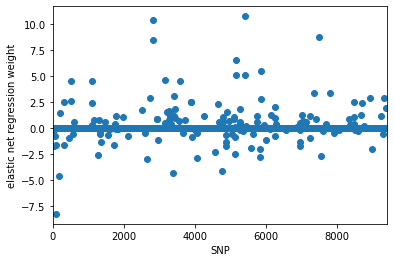

In [91]:
plt.figure(figsize = (6, 4))
plt.scatter(range(p), # x = SNP position
            model_l1l2.best_estimator_.coef_)  # y = regression weights

plt.xlabel("SNP")
plt.ylabel("elastic net regression weight")
plt.xlim([0, p])

__How can you interpret these results? How many SNPs contribute to explaining the phenotype?__

In [92]:
print("%d SNPs selected." % \
    np.nonzero(model_l1l2.best_estimator_.coef_)[0].shape)

169 SNPs selected.


### Predictive power 

In [93]:
y_2W_l1l2_pred = model_l1.best_estimator_.predict(X_2W_te)

print("Percentage of variance explained (using %d SNPs): %.2f" % \
     (np.nonzero(model_l1l2.best_estimator_.coef_)[0].shape[0], 
      metrics.explained_variance_score(y_2W_te, y_2W_l1_pred)))

Percentage of variance explained (using 169 SNPs): 0.60


(13.95, 125.05)

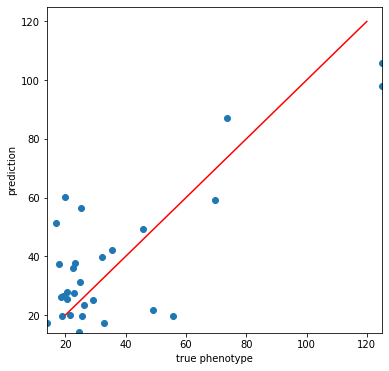

In [95]:
plt.figure(figsize = (6, 6))
plt.scatter(y_2W_te, y_2W_l1l2_pred)
plt.plot([20, 120], [20, 120], c = "red")
plt.xlabel("true phenotype")
plt.ylabel("prediction")
plt.xlim([np.min(y_2W_te) - 0.05, np.max(y_2W_te) + 0.05])
plt.ylim([np.min(y_2W_te) - 0.05, np.max(y_2W_te) + 0.05])

### Stability

__How stable is the set of selected SNPs, between the different rounds of cross-validation with optimal parameters?__

## Stability selection with the Lasso

__Use a randomized procedure to stabilize the lasso__

[sklearn.linear_model.RandomizedLasso.html](http://scikit-learn.org/0.18/modules/generated/sklearn.linear_model.RandomizedLasso.html#sklearn.linear_model.RandomizedLasso) + [User Guide](http://scikit-learn.org/0.18/auto_examples/linear_model/plot_sparse_recovery.html)

## Network-constrained lasso

This is not implemented in scikit-learn, so we'll need to create our own estimator.

It turns out that it is possible to transform the network-constrained Lasso problem into a Lasso problem: follow [the original paper](https://academic.oup.com/bioinformatics/article/24/9/1175/206444) (pdf also available [here](http://www.stat.purdue.edu/~doerge/BIOINFORM.D/FALL10/Li_and_Li_2008_Bioinformatics.pdf) and the note in section C of [the supplementary material of Sugiyama et al. (2014)](http://cazencott.info/dotclear/public/publications/sugiyama2014_supp.pdf) to replace the eigen-decomposition of the graph Laplacian with the graph incidence matrix.

Follow the [documentation](http://scikit-learn.org/stable/developers/contributing.html#rolling-your-own-estimator) or this [blog post](http://danielhnyk.cz/creating-your-own-estimator-scikit-learn/) to create a scikit-learn estimator.

Be careful: the computations might require a lot of RAM.

### Load the network

In [96]:
from scipy import sparse

In [97]:
w_saved = np.loadtxt('data/athaliana_small.W.txt')

In [98]:
W = sparse.coo_matrix((w_saved[2, :], (np.array(w_saved[0, :], dtype = int), 
                                       np.array(w_saved[1, :], dtype = int))), 
                      shape = (p, p))

### Build the incidence matrix

In [99]:
# Compute node degrees 
degrees = np.zeros((p, ))
for vertex in W.row:
    degrees[vertex] += 2

In [103]:
W.row

array([   0,    0,    0, ..., 9418, 9418, 9418], dtype=int32)

In [104]:
tim = sparse.lil_matrix((W.row.shape[0], p))
for ix, edge in enumerate(W.data):
    tim[ix, W.row[ix]] = np.sqrt(edge / degrees[W.row[ix]])
    tim[ix, W.col[ix]] = - np.sqrt(edge / degrees[W.col[ix]])

### Create the network-constrained Lasso class

In [108]:
from sklearn import base, linear_model

In [109]:
class ncLasso(base.BaseEstimator, base.RegressorMixin):
    def __init__(self, transposed_incidence = None, lambda1 = 1.0, lambda2 = 1.0):
        self.transposed_incidence = transposed_incidence # sparse matrix
        self.lambda1 = lambda1
        self.lambda2 = lambda2
        
    def fit(self, X, y):       
        alpha = self.lambda1/(np.sqrt(self.lambda2 + 1.))
        self.lasso = linear_model.Lasso(fit_intercept = True, alpha = alpha)
        
        
        y_new = np.hstack((y, np.zeros((self.transposed_incidence.shape[0], ))))
        print(y_new.shape, X.shape)
        X_new = 1 / (np.sqrt(self.lambda2 + 1)) * sparse.vstack((X, np.sqrt(self.lambda2) *\
                                                    self.transposed_incidence))
        
        
        self.lasso.fit(X_new, y_new)
        self.coef_ = self.lasso.coef_[:X.shape[1]] / (np.sqrt(self.lambda2 + 1))
        return self
        
        
    def predict(self, X, y = None):
        return self.lasso.predict(X)
    
    
    def score(self, X, y = None):
        return self.lasso.score(X, y)                                        

__Use the network-constrained Lasso on the data. What do you observe?__

In [112]:
nclasso_model = ncLasso(tim, 1, 1)
nclasso_model.fit(X_2W_tr, y_2W_tr)

(1291764,) (121, 9419)


ncLasso(lambda1=1, lambda2=1,
        transposed_incidence=<1291643x9419 sparse matrix of type '<class 'numpy.float64'>'
	with 2582679 stored elements in List of Lists format>)

In [114]:
plt.figure(figsize = (6, 4))
plt.scatter(range(p), # x = SNP position
            nclasso_model.best_estimator_.coef_)  # y = regression weights

plt.xlabel("SNP")
plt.ylabel("elastic net regression weight")
plt.xlim([0, p])

AttributeError: 'ncLasso' object has no attribute 'best_estimator_'

<Figure size 432x288 with 0 Axes>

If you want to use SConES/sfan, see [github/chagaz/sfan](https://github.com/chagaz/sfan). The StructuredSparsity notebook can help.

## Multi-task feature selection

1) Repeat the previous analysis for the 4W phenotype. It is very similar to the 2W phenotype, except that the seeds have been vernelized for 4 weeks. 

2) It is not unreasonable to expect the genomic regions driving both those phenotypes to be (almost) the same. Use the multi-task version of the Lasso, ENet, or ncLasso algorithms to analyzed both phenotypes simultaneously.

Use [sklearn.linear_model.MultiTaskLasso](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.MultiTaskLasso.html#sklearn.linear_model.MultiTaskLasso) + [User Guide](http://scikit-learn.org/stable/auto_examples/linear_model/plot_multi_task_lasso_support.html)